[View in Colaboratory](https://colab.research.google.com/github/rdenadai/DSP-Study-Notebooks/blob/master/notebooks/dsp101d.ipynb)

## DSP 101d

Experiments on Digital Signal Processing, ranging from random generated signals, voice and images!

In these experiments, we are not analysing signals in the range of DSP but also with an statistical view...

To build this document we use a lot of resources, here are some of the most important.
- References:
 - [DSP Guide](http://www.dspguide.com)
 - [Understand the Fourier transform and its applications](https://www.udemy.com/fourier-transform-mxc/)
 - [MikeXCohen Lectures](http://www.mikexcohen.com/left_toc.html)
 - [Elegant SciPy](https://github.com/elegant-scipy/elegant-scipy)
 - [DSP Tutorial](https://www.tutorialspoint.com/digital_signal_processing/index.htm)
 - [Plotly FFT Filters](https://plot.ly/python/fft-filters/)
 - [Digital Signal Processing {youtube}](https://www.youtube.com/playlist?list=PLuh62Q4Sv7BUSzx5Jr8Wrxxn-U10qG1et)
 - [Signal Processing 101 {youtube}](https://www.youtube.com/watch?v=KZd68xgasIU&list=PLJ-OcUCIty7evBmHvYRv66RcuziszpSFB)
 - [All Signal Processing {youtube}](https://www.youtube.com/user/allsignalprocessing/playlists)


In [0]:
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.signal import resample, hilbert
from scipy import interpolate
from scipy import fftpack
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import Audio

%matplotlib inline

def normalization(x, m=255):
    return (((x - min(x)) / (max(x) - min(x))) * m).astype('int64')

def normalization2(x, a, b):
    return (a + (((x - min(x)) * (b - a)) / (max(x) - min(x)))).astype('float64')

def sine(A=4096, f=1, t=1, Fs=1024, phi=0, dtype=np.int64):
    n = np.arange(Fs * t)
    return (A * np.sin((((2 * np.pi * f) * n) / Fs) + phi)).astype(dtype)

def cosine(A=4096, f=1, t=1, Fs=1024, phi=0, dtype=np.int64):
    n = np.arange(Fs * t)
    return (A * np.cos((((2 * np.pi * f) * n) / Fs) + phi)).astype(dtype)

def complex_wave(A=1, f=1, t=1, Fs=1024, phi=0):
    n = np.arange(Fs * t)
    return (A * np.exp((((2 * np.pi * f) * n) / Fs) * 1j + phi))

## Frequency Resolution

> *"**Frequency resolution is the distance in Hz between two adjacent data points in the DFT**. The frequency resolution of a DFT is defined as $\frac{F_s}{N}$. Where $F_s$ is the sampling rate and $N$ is the number of data points. The denominator can be expressed in terms of sampling rate and time, $N=F_st$. In other words, **the only thing that increases frequency resolution is time**. Changes in sampling rate do nothing towards increasing the frequency resolution if the actual time span of your signal is the same. By increasing the sampling rate, you're only increasing the frequency coverage. Your frequency axis will span more values, but they will be spaced the same distance in Hz as the lower sampling rate.
"* [Quora](http://qr.ae/TUI1Mf)

Frequencies X1[n]:  [3.  3.5]
Frequencies X2[n]:  [ 5.   9.8 10.2]


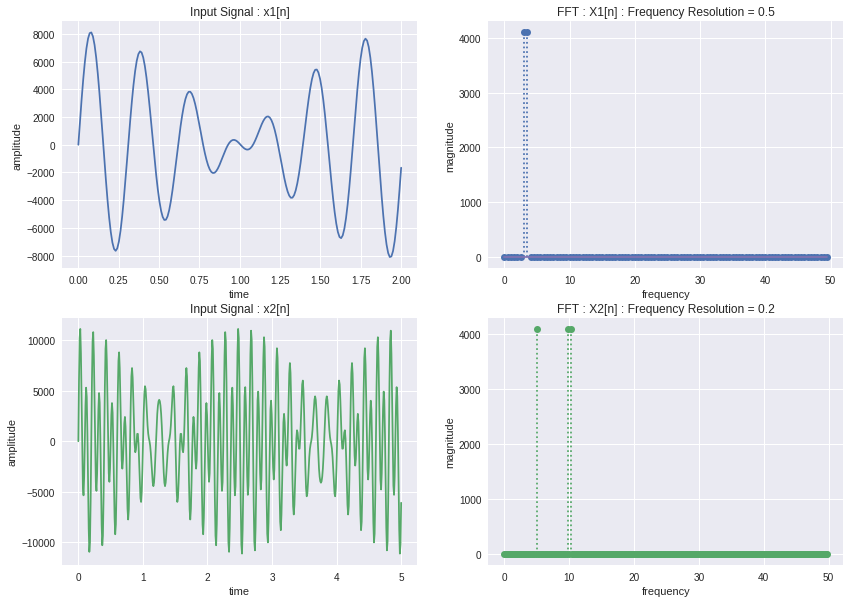

In [2]:
def frequency_resolution(x, t):
    Fs = int(x.size / t)
    X = fftpack.fft(x)
    nyquist = int(x.size / 2)
    time = np.linspace(0, t, Fs * t)
    freqs = (fftpack.fftfreq(x.size) * Fs).astype('float32')
    mag = 2 * (np.abs(X) / x.size)
    return x, mag[:nyquist], time, freqs[:nyquist]

Fs = 100

t = 2
x1 = sine(f=3, t=t, Fs=Fs, dtype=np.float32) + \
     sine(f=3.5, t=t, Fs=Fs, dtype=np.float32)
x1, X1, time1, freqs1 = frequency_resolution(x1, t)
res1 = Fs/x1.size
print('Frequencies X1[n]: ', np.where(X1 > 10)[0] * res1)

t = 5
x2 = sine(f=5, t=t, Fs=Fs, dtype=np.float32) + \
     sine(f=9.8, t=t, Fs=Fs, dtype=np.float32) + \
     sine(f=10.2, t=t, Fs=Fs, dtype=np.float32)
x2, X2, time2, freqs2 = frequency_resolution(x2, t)
res2 = Fs/x2.size
print('Frequencies X2[n]: ', np.where(X2 > 10)[0] * res2)

plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.title('Input Signal : x1[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time1, x1)
plt.subplot(222)
plt.title(f'FFT : X1[n] : Frequency Resolution = {res1}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs1, X1, linefmt='C0:')
plt.subplot(223)
plt.title('Input Signal : x2[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time2, x2, color='C1')
plt.subplot(224)
plt.title(f'FFT : X2[n] : Frequency Resolution = {res2}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs2, X2, linefmt='C1:', markerfmt='C1o', basefmt='C1')
plt.show()

### Zero-padding in Time Domain

"*Zero padding in time domain correspond to ideal interpolation in the frequency domain.*" [JOS CCRMA Stanford](https://ccrma.stanford.edu/~jos/sasp/Zero_Padding_Time_Domain.html)

"*Sometimes people will say that zero-padding in the time domain yields higher spectral resolution in the frequency domain. However, signal processing practitioners should not say that, because 'resolution' in signal processing refers to the ability to 'resolve' closely spaced features in a spectrum analysis. The usual way to increase spectral resolution is to **take a longer DFT without zero padding**...*" [JOS CCRMA Stanford](https://ccrma.stanford.edu/~jos/mdft/Zero_Padding_Applications.html)

Besides the above citation, which observes the correct way to implement better frequency resolution, the bellow example shows the use of zero padding in time domain, in a certain way to improve **frequency peak resolve**, make it possible to find lower and lower frequencies.


In [0]:
def zero_padding_time_domain(x, t=1, resolution=40):
    Fs_org = x.size
    res = int(np.ceil(resolution))
    # In this line we are actually doing the zero padding at end
    x = np.append(x, np.zeros(res))
    X = 2 * np.abs(fftpack.fft(x)) / Fs_org
    
    Fs = x.size
    time = np.linspace(0, t, Fs)
    freqs = (fftpack.fftfreq(x.size) * Fs_org / t).astype('float32')
    nyquist = int(len(freqs) / 5)
    return x, X[:nyquist], time, freqs[:nyquist]

def find_frequecies(X, resolution):
    return np.where(X > (np.max(X) - np.mean(X)))[0] * resolution

Frequencies X1[n]:  [0.]
Frequencies X2[n]:  [0.         0.16666667 0.33333333]


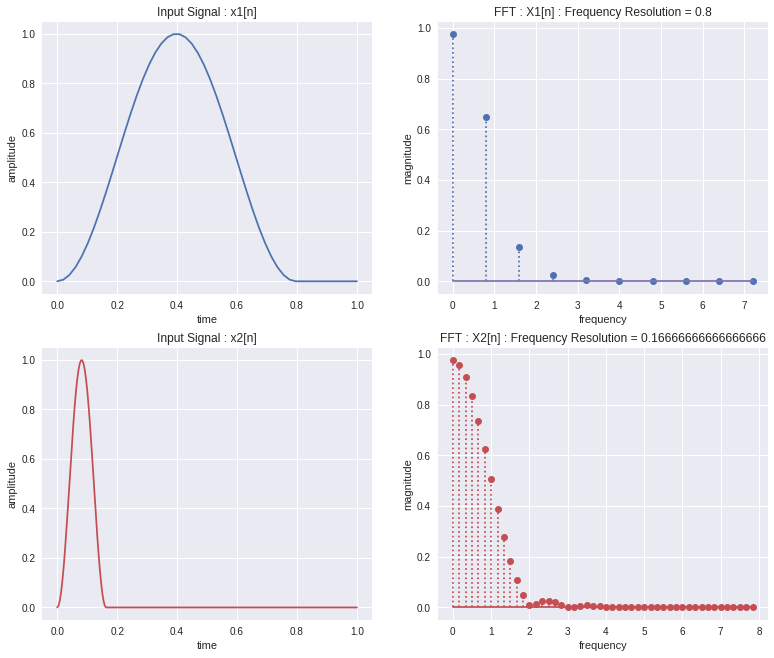

In [4]:
Fs = 40
x1 = np.hanning(Fs)
x1, X1, time1, freqs1 = zero_padding_time_domain(x1, 1, 10)

x2 = np.hanning(Fs)
x2, X2, time2, freqs2 = zero_padding_time_domain(x2, 1, Fs * 5)

res1 = Fs/x1.size
res2 = Fs/x2.size
print('Frequencies X1[n]: ', find_frequecies(X1, res1))
print('Frequencies X2[n]: ', find_frequecies(X2, res2))

plt.figure(figsize=(13, 11))
plt.subplot(221)
plt.title('Input Signal : x1[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time1, x1)
plt.subplot(222)
plt.title(f'FFT : X1[n] : Frequency Resolution = {Fs/x1.size}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs1, X1, linefmt='C0:')
plt.subplot(223)
plt.title('Input Signal : x2[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time2, x2, color='C2')
plt.subplot(224)
plt.title(f'FFT : X2[n] : Frequency Resolution = {Fs/x2.size}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs2, X2, linefmt='C2:', markerfmt='C2o', basefmt='C2')
plt.show()

Frequencies X1[n]:  [3.25 9.75]
Frequencies X2[n]:  [ 5.         15.66666667]


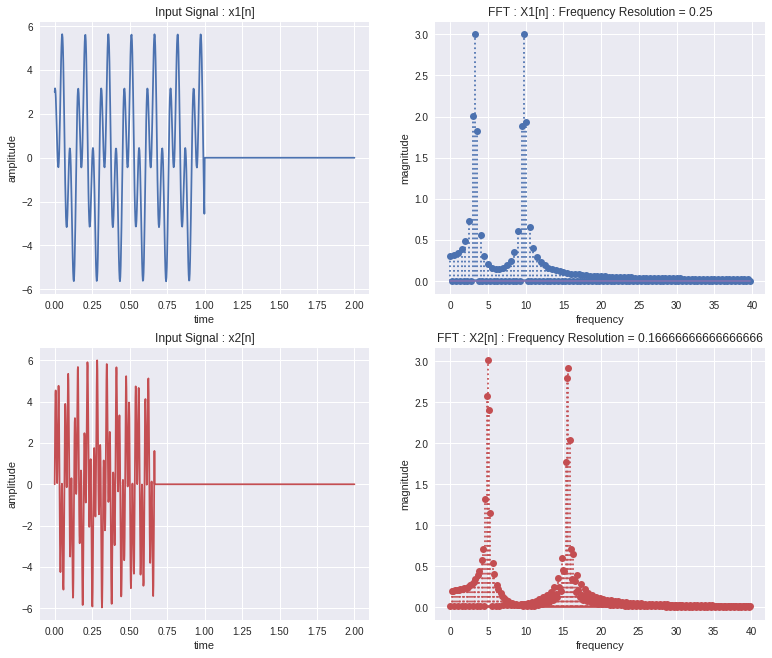

In [5]:
t = 2
Fs = 200
x1 = sine(A=3, f=3.25, t=t, Fs=Fs, dtype=np.float32) + \
     cosine(A=3, f=9.75, t=t, Fs=Fs, dtype=np.float32)
x1, X1, time1, freqs1 = zero_padding_time_domain(x1, t, Fs * 2)

x2 = sine(A=3, f=5, t=t, Fs=Fs, dtype=np.float32) + \
     sine(A=3, f=15.6, t=t, Fs=Fs, dtype=np.float32)
x2, X2, time2, freqs2 = zero_padding_time_domain(x2, t, Fs * 4)

res1 = Fs/x1.size
res2 = Fs/x2.size
print('Frequencies X1[n]: ', find_frequecies(X1, res1))
print('Frequencies X2[n]: ', find_frequecies(X2, res2))

plt.figure(figsize=(13, 11))
plt.subplot(221)
plt.title('Input Signal : x1[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time1, x1)
plt.subplot(222)
plt.title(f'FFT : X1[n] : Frequency Resolution = {Fs/x1.size}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs1, X1, linefmt='C0:')
plt.subplot(223)
plt.title('Input Signal : x2[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time2, x2, color='C2')
plt.subplot(224)
plt.title(f'FFT : X2[n] : Frequency Resolution = {Fs/x2.size}')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs2, X2, linefmt='C2:', markerfmt='C2o', basefmt='C2')
plt.show()

### Zero-padding in Frequency Domain

The same thing the was accomplished above, doing zero-padding in time domain, can be inversed done in frequency doman.

This interpolation of newer points add to the frequency must be done in the middle of the spectrum... this means that we are adding the zero padding right in the middle of the frequency spectrum.

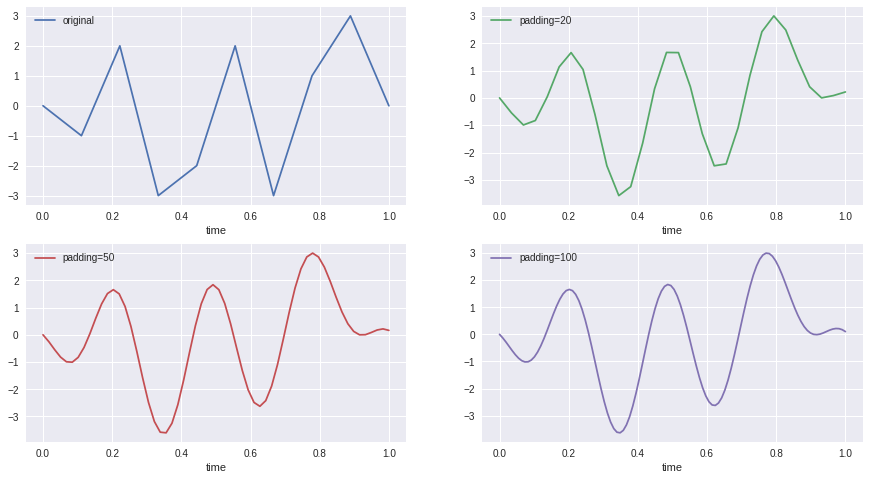

In [6]:
def zero_padding_frequency_domain(x, padding=10):
    l = int(np.floor(x.size / 2))
    X = fftpack.fft(x)
    Xa = np.append(X[:l], np.zeros(padding))
    Xa = np.append(Xa, X[l:])
    xn = fftpack.ifft(Xa).real
    norm = np.max(x) / np.max(xn)
    return np.linspace(0, 1, xn.size), xn * norm

x = np.array([0, -1, 2, -3, -2, 2, -3, 1, 3, 0])
s = x.size

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, 1, s), x, label='original')
plt.xlabel('time')
plt.legend()
for i, z in enumerate([s*2, s*5, s*10]):
    time, signal = zero_padding_frequency_domain(x, z)
    plt.subplot(2, 2, i+2)
    plt.plot(time, signal, label=f'padding={z}', color=f'C{i+1}')
    plt.xlabel('time')
    plt.legend()
plt.show()

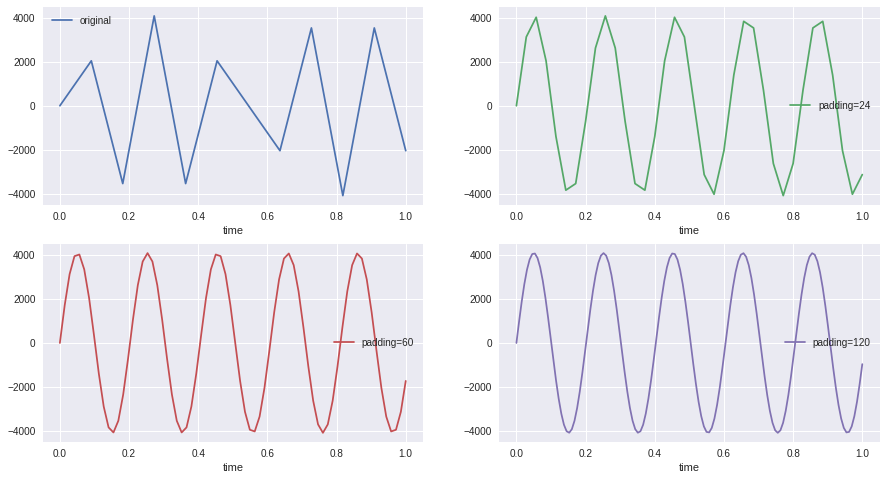

In [7]:
# To avoid aliasing using a Fs of 2B
x = sine(f=5, t=1, Fs=12, dtype=np.float32)
s = x.size

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, 1, s), x, label='original')
plt.xlabel('time')
plt.legend()
for i, z in enumerate([s*2, s*5, s*10]):
    time, signal = zero_padding_frequency_domain(x, z)
    plt.subplot(2, 2, i+2)
    plt.plot(time, signal, label=f'padding={z}', color=f'C{i+1}')
    plt.xlabel('time')
    plt.legend()
plt.show()

Just for comparison, bellow we show how the interpolation can almost recreate the same signal as one capture with great sampling rate.

Is normal and x padded equals:  True


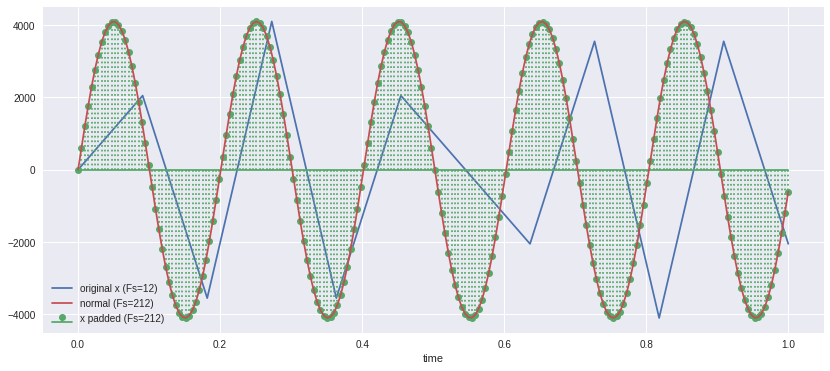

In [8]:
x = sine(f=5, t=1, Fs=12, dtype=np.float32)
time, padded = zero_padding_frequency_domain(x, 200)
normal = sine(f=5, t=1, Fs=212, dtype=np.float32)

print('Is normal and x padded equals: ', sum(normal-padded) < 1E-10)

plt.figure(figsize=(14, 6))
plt.plot(np.linspace(0, 1, 12), x, label='original x (Fs=12)')
plt.stem(time, padded, label='x padded (Fs=212)', linefmt='C1:', markerfmt='C1o', basefmt='C1')
plt.plot(time, normal, label='normal (Fs=212)', color='C2')
plt.legend()
plt.xlabel('time')
plt.show()

### Aliasing

*"Aliasing is an effect that causes different signals to become indistinguishable when sampled. It also refers to the distortion or artifact that results when the signal reconstructed from samples is different from the original continuous signal."* [wiki](https://en.wikipedia.org/wiki/Aliasing)

To avoid aliasing when sampling a signal (specially in continuous time) is to apply the **Nyquist-Shannon sampling theorem**, that states:

Any signal should be sampled at least 2x it's bandlimited frequency. [wiki](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)

> *A sufficient sample-rate is therefore $2B$ samples/second, or anything larger. Equivalently, for a given sample rate $F_s$, perfect reconstruction is guaranteed possible for a bandlimit $B < \frac{F_s}{2}$.*

This means that $F_s > 2 \times B$. 

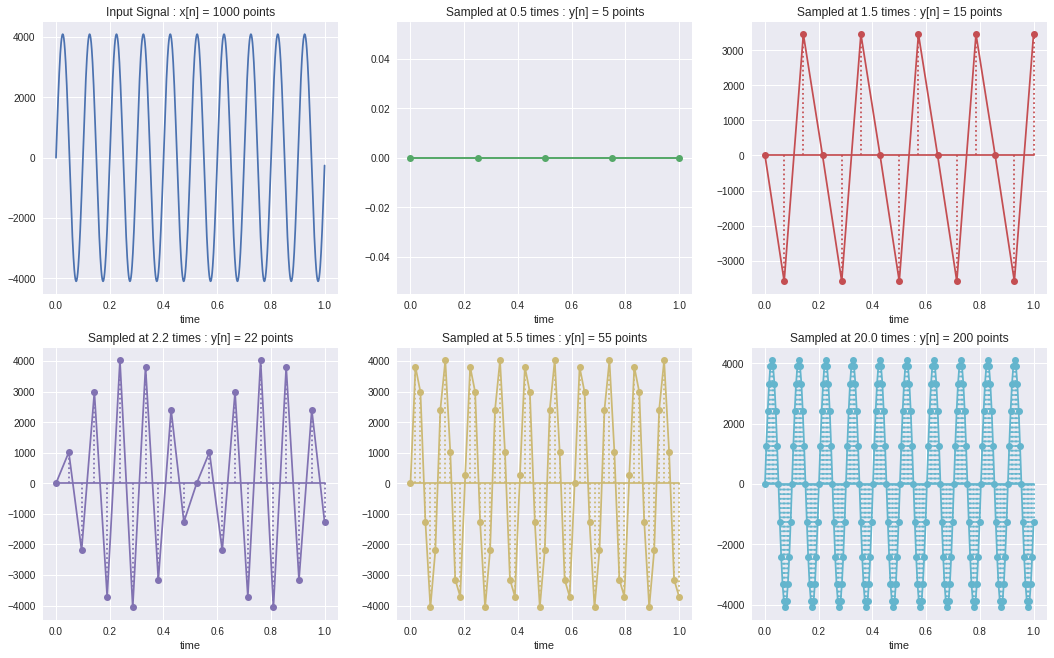

In [9]:
f = 10
t = 1
Fs = 1000
time = np.linspace(0, t, Fs * t, dtype=np.float32)
x = sine(f=f, t=t, Fs=Fs)

plt.figure(figsize=(18, 11))
plt.subplot(2, 3, 1)
plt.plot(time, x)
plt.title(f'Input Signal : x[n] = {x.size} points')
plt.xlabel('time')
srates = [5, 15, 22, 55, 200]  # in Hz
for i, rt in enumerate(srates):
    idx = np.ceil(np.arange(0, Fs, Fs/rt)).astype('int32')
    y = x[idx]
    time_y = np.linspace(0, t, y.size, dtype=np.float32)
    plt.subplot(2, 3, i+2)
    plt.title(f'Sampled at {rt/10} times : y[n] = {y.size} points')
    plt.plot(time_y, y, color=f'C{i+1}')
    plt.stem(time_y, y, linefmt=f'C{i+1}:', markerfmt=f'C{i+1}o', basefmt=f'C{i+1}')
    plt.xlabel('time')
plt.show()

A more direct example of sampling rate when getting close to Nyquist is the following

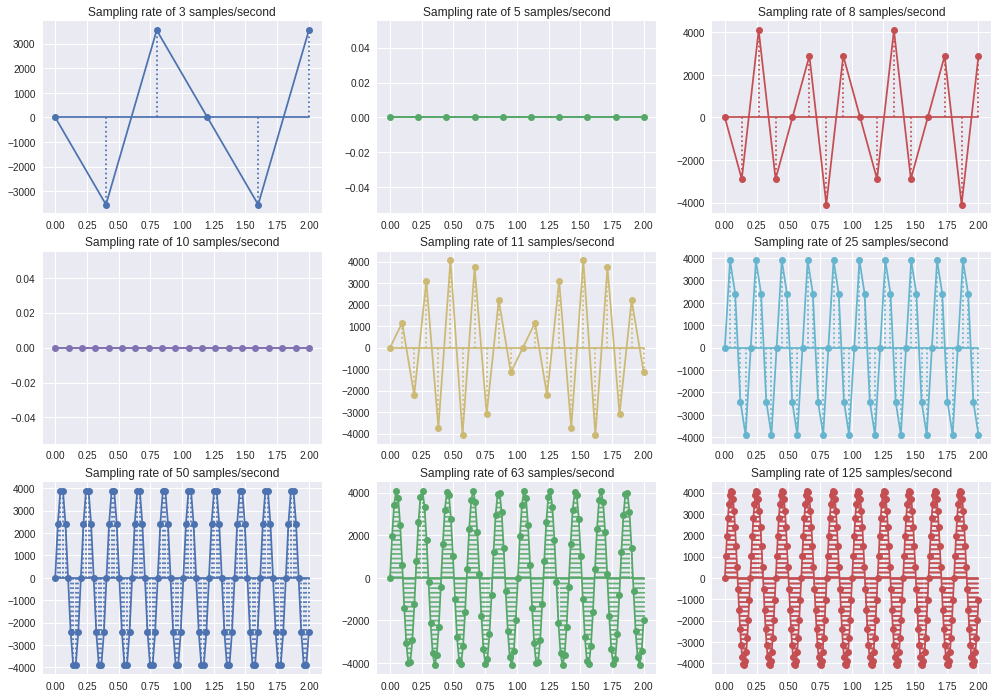

In [10]:
f = 5 # frequency
t = 2 # time

plt.figure(figsize=(17, 12))
for i, srate in enumerate([.5, 1, 1.5, 2, 2.1, 5, 10, 12.5, 25]):
    Fs = int(np.ceil(f * srate))
    time = np.linspace(0, t, Fs * t)
    x = sine(f=f, t=t, Fs=Fs, dtype=np.float16)
    plt.subplot(3, 3, i + 1)
    plt.title(f'Sampling rate of {Fs} samples/second')
    plt.stem(time, x, linefmt=f'C{i}:', markerfmt=f'C{i}o', basefmt=f'C{i}')
    plt.plot(time, x, color=f'C{i}')
plt.show()

**REMEMBER**: One should never sample at Nyquist rate because otherwise one could not define correct frequency of diferent sine waves.

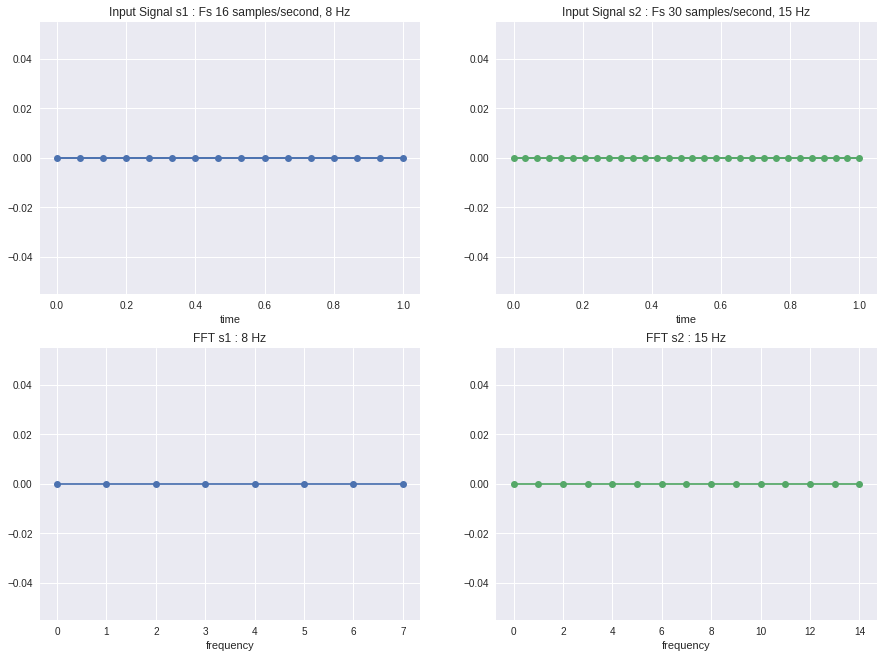

In [11]:
def closest_to_nyquist(f, t, nyquist=2.0):
    Fs = int(np.ceil(f * nyquist)) # Nyquist rate
    time = np.linspace(0, t, Fs * t)    
    s = sine(f=f, t=t, Fs=Fs, dtype=np.float16)
    freqs = (fftpack.fftfreq(s.size) * Fs * t)
    ny = int(np.ceil(len(freqs)/2))
    freqs = freqs[:ny]
    S = (2 * np.abs(fftpack.fft(s)) / s.size)[:ny]
    return Fs, s, S, time, freqs

f1 = 8
f2 = 15
Fs1, s1, S1, time1, freqs1 = closest_to_nyquist(f=f1, t=1, nyquist=2.0)
Fs2, s2, S2, time2, freqs2 = closest_to_nyquist(f=f2, t=1, nyquist=2.0)

plt.figure(figsize=(15, 11))
plt.subplot(2, 2, 1)
plt.title(f'Input Signal s1 : Fs {Fs1} samples/second, {f1} Hz')
plt.stem(time1, s1, linefmt='C0:', markerfmt='C0o', basefmt='C0')
plt.plot(time1, s1, color='C0')
plt.xlabel('time')
plt.subplot(2, 2, 2)
plt.title(f'Input Signal s2 : Fs {Fs2} samples/second, {f2} Hz')
plt.stem(time2, s2, linefmt='C1:', markerfmt='C1o', basefmt='C1')
plt.plot(time2, s2, color='C1')
plt.xlabel('time')
plt.subplot(2, 2, 3)
plt.title(f'FFT s1 : {f1} Hz')
plt.stem(freqs1, S1, linefmt='C0:', markerfmt='C0o', basefmt='C0')
plt.xlabel('frequency')
plt.subplot(2, 2, 4)
plt.title(f'FFT s2 : {f2} Hz')
plt.stem(freqs2, S2, linefmt='C1:', markerfmt='C1o', basefmt='C1')
plt.xlabel('frequency')
plt.show()

### Stationary and non-stationary

"*Stationary and non-stationary are characteristics of the process which has generated the signal. A signal can be considered as an observation. It is an observation of a series of events that have happened as a result of some process. If the properties of the process which generates the events DO NOT change in time, then the process is stationary.*" [Quora](https://www.quora.com/What-are-stationary-signals-and-examples)

Features of a signal that change over a period classify the signal as stationary or non-stationary.

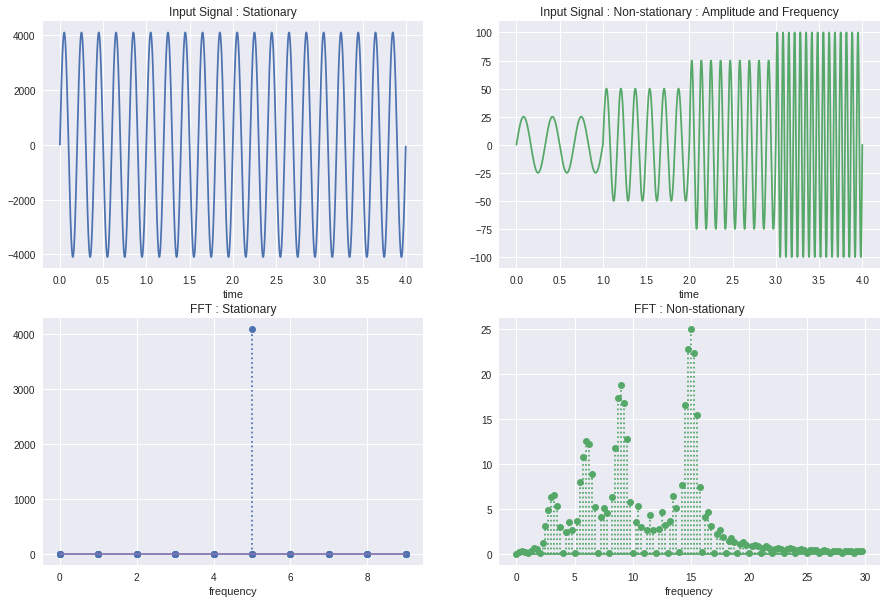

In [12]:
f = 5
t = 4
Fs = 2048
time = np.linspace(0, t, Fs * t)
stationary = sine(f=f, t=t, Fs=Fs, dtype=np.float32)

tn = 4
fn = 0
nonstationary = np.zeros(Fs * tn)
k = 0
A = [25, 50, 75, 100]
for i, m in enumerate([3, 6, 9, 15]):
    n = np.linspace(i, i+1, Fs)
    x = (A[i] * np.sin((((2 * np.pi * m) * n)))).astype(np.float32)
    nonstationary[k:k+Fs] = x
    k += Fs
    fn = m
timen = np.linspace(0, tn, nonstationary.size)

X = (2 * np.abs(fftpack.fft(stationary)) / stationary.size)
frq = (fftpack.fftfreq(Fs * t) * Fs).astype(np.int16)
ny = int(f * 2 * t)
Xn = (2 * np.abs(fftpack.fft(nonstationary)) / nonstationary.size)
frqn = (fftpack.fftfreq(Fs * tn) * Fs).astype(np.float16)
nyn = int(fn * 2 * tn)

frqn, Xn = frqn[:nyn], Xn[:nyn]

# My method only works if frequencies are of the same amplitude...
# a better approuch would be to use a windowing. see bellow
# frs = find_frequecies(Xn, (Fs / nonstationary.size))
# frs = frs[np.where(np.ceil(frs) - frs == 0)]
# print('Frequencies: ', frs)

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title('Input Signal : Stationary')
plt.plot(time, stationary)
plt.xlabel('time')
plt.subplot(222)
plt.title('Input Signal : Non-stationary : Amplitude and Frequency')
plt.plot(timen, nonstationary, color='C1')
plt.xlabel('time')
plt.subplot(223)
plt.title('FFT : Stationary')
plt.stem(frq[:ny], X[:ny], linefmt='C0:')
plt.xlabel('frequency')
plt.subplot(224)
plt.title('FFT : Non-stationary')
plt.stem(frqn, Xn, linefmt='C1:', markerfmt='C1o', basefmt='C1')
plt.xlabel('frequency')
plt.show()

The second input signal is a non-stationary in both amplitude and frequency, making it gain energy over the periodo of time, this could be seen in the FFT of the signal.

### Time-Frequency Analysis

"*In signal processing, time–frequency analysis comprises those techniques that study a signal in both the time and frequency domains simultaneously, using various time-frequency representations. Rather than viewing a 1-dimensional signal (a function, real or complex-valued, whose domain is the real line) and some transform (another function whose domain is the real line, obtained from the original via some transform), time-frequency analysis studies a two-dimensional signal - a function whose domain is the two-dimensional real plane, obtained from the signal via a time-frequency transform.*" [wiki](https://en.wikipedia.org/wiki/Time%E2%80%93frequency_analysis)

"*One of the most basic forms of time–frequency analysis is the **short-time Fourier transform (STFT)**, but more sophisticated techniques have been developed, notably **wavelets**.*" [wiki](https://en.wikipedia.org/wiki/Time%E2%80%93frequency_analysis)


#### 1. Short-time FFT (STFT)

"*The short-time Fourier transform (STFT), is a Fourier-related transform used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time.*" [wiki](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)

In example bellow we define a window which will get small chunks of the signal and compute the FFT. After that we will build the Frequency-Power Spectrum, which will demonstrate the slow slope in frenquency over time.

In order to smooth the Time-Frequency power spectrum of the result given by STFT we use a [Hann Window](https://en.wikipedia.org/wiki/Hann_function), which is given by:

$w(n) = \frac{1}{2}(1 - \cos(\frac{2 \pi n}{N-1}))$

#### 2. Complex Morlet Wavelet Convolution

"*A wavelet is a wave-like oscillation with an amplitude that begins at zero, increases, and then decreases back to zero. It can typically be visualized as a "brief oscillation" like one recorded by a seismograph or heart monitor. Generally, wavelets are intentionally crafted to have specific properties that make them useful for signal processing. Using a "reverse, shift, multiply and integrate" technique called convolution, wavelets can be combined with known portions of a damaged signal to extract information from the unknown portions.*" [wiki](https://en.wikipedia.org/wiki/Wavelet)

"*...wavelet transformation is good in time resolution of high frequencies, while for slowly varying functions, the frequency resolution is remarkable.*" [wiki](https://en.wikipedia.org/wiki/Wavelet_transform)

Example two in the graph bellow show the same representation calculate above, but instead of using STFT we are using a Morlet Wavelet convoluted with the signal im frequency.

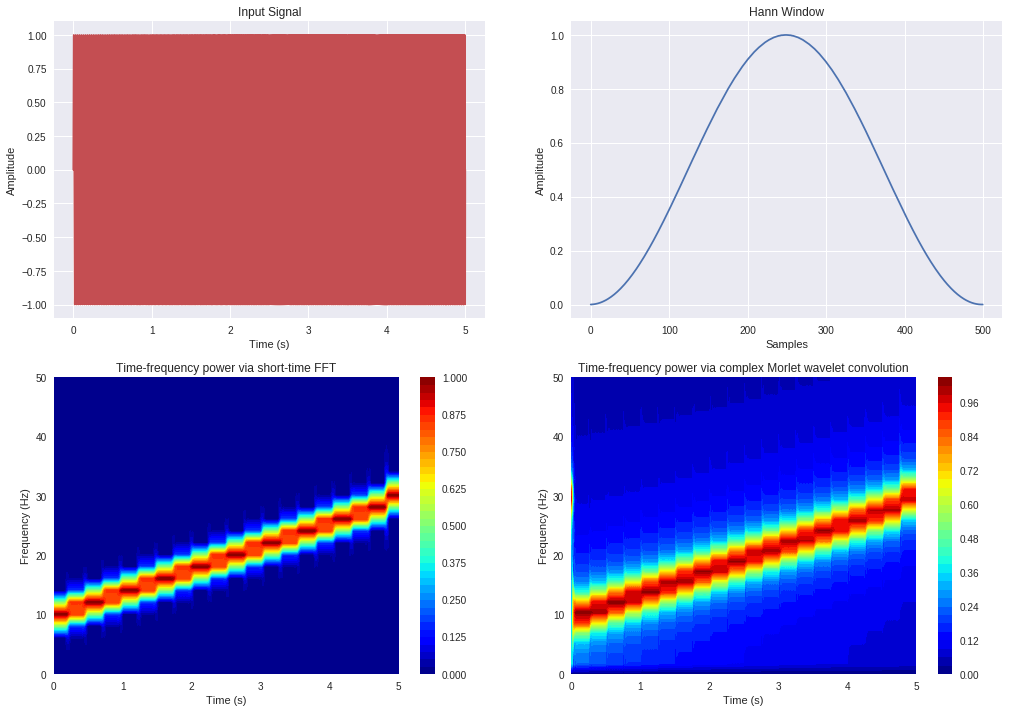

In [13]:
Fs = 1000
tn = 5
ff = np.linspace(10, 30, 20).astype(np.int32)
signal = np.zeros(Fs * len(ff))
# Generate a non-stationary signal with different amplitude and frequency
A = [1] # [25, 50, 75, 100, 125]
k = 0
for i, m in enumerate(ff):
    n = np.linspace(i, i+1, Fs)
    p = np.random.choice(A)
    x = (p * np.sin((((2 * np.pi * m) * n)))).astype(np.float32)
    signal[k:k+Fs] = x
    k += Fs
time = np.linspace(0, tn, signal.size)


# STFT example
# -----------------------------------
npnts = signal.size
winlen = 500  # window length
stepsize = 25  # step size
numsteps = int(np.floor((npnts-winlen)/stepsize))

# Frequencies to show in power
hz = np.linspace(0, Fs/2, int(np.floor(winlen/2)))

# Create the time-frequency power
tf = np.zeros((len(hz), numsteps), dtype=np.float16)

# hann window
hwin = (.5 * (1 - np.cos(2 * np.pi * np.arange(1, winlen+1) / (winlen-1)))).astype(np.float16)

# STFT loop
for ti in range(1, numsteps):
    tapdata = signal[(ti-1)*stepsize:(ti-1)*stepsize+winlen]
    x = fftpack.fft(hwin * tapdata);
    m = (2 * np.abs(x[0:len(hz)]) / winlen) * 2  # x2 because of hann normalize
    tf[:,ti] = m


# Morlet Wavelet example
# -----------------------------------
nfrex = 30
frex  = np.linspace(0, 50, nfrex)
wtime = np.linspace(0, tn, Fs * tn)
gausS = np.linspace(0, 50, nfrex)

tfm = np.zeros((nfrex, npnts))
# FFT of signal
signalX = fftpack.fft(signal, len(signal))
# Morlet loop
for fi in range(1, nfrex):
    s = (gausS[fi] / (2 * np.pi * frex[fi])) ** 2
    cmw = np.exp(1j * 2 * np.pi * frex[fi] * wtime) * np.exp( (-wtime ** 2) / s)
    
    # FFT of morlet wavelet with padding
    cmwX = fftpack.fft(cmw, len(signalX))
    cmwX = cmwX / np.max(cmwX)
    
    convres = fftpack.ifft(signalX * cmwX)
    tfm[fi,:] = 2 * np.abs(convres)

    
# Presentation
# -----------------------------------
plt.figure(figsize=(17, 12))
plt.subplot(221)
plt.title('Input Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(time, signal, color='C2')
plt.subplot(222)
plt.title('Hann Window')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.plot(hwin, color='C0')
plt.subplot(223)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power via short-time FFT')
plt.contourf(np.linspace(0, tn, numsteps), hz, tf, 40, cmap='jet')
plt.colorbar()
plt.ylim([0, 50])
plt.xlim([0, 5])
plt.subplot(224)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power via complex Morlet wavelet convolution')
plt.contourf(time, frex, tfm, 40, cmap='jet')
plt.colorbar()
plt.ylim([0, 50])
plt.xlim([0, 5])
plt.show()

### Windowing (Welch's Method)

"*Welch's method (also called the periodogram method) for estimating power spectra is carried out by dividing the time signal into successive blocks, forming the periodogram for each block, and averaging.*" [dsprelated.com](https://www.dsprelated.com/freebooks/sasp/Welch_s_Method.html)


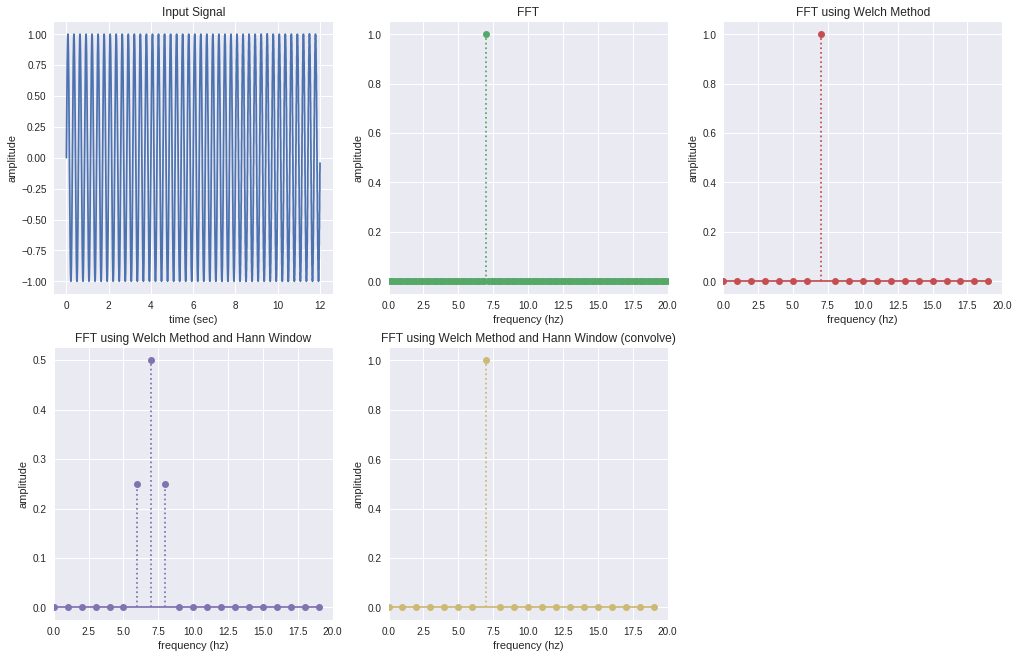

In [14]:
Fs = 1024
f = 7
t = 6
qtd = 2

s1 = sine(A=1, f=f, t=t, Fs=Fs, dtype=np.float64)
s2 = sine(A=1, f=f, t=t, Fs=Fs, phi=np.pi, dtype=np.float64)
s = np.append(s1, s2)
s = s1
time = np.linspace(0, t * qtd, s.size, dtype=np.float16)
fqs = (fftpack.fftfreq(s.size) * Fs).astype(np.float16)
S = 2 * np.abs(fftpack.fft(s)) / s.size

# Welch Method
# ------------------------------------------------
window = int(np.ceil(Fs))
k = int(np.ceil((s.size) / window))
p = 0
wtf = np.zeros(window)
wtfh = np.zeros(window)
wtfch = np.zeros(window)

# hann window
hwin = (.5 * (1 - np.cos(2 * np.pi * np.arange(1, window+1) / (window-1)))).astype(np.float16)

for i in range(k):
    # Window
    tp = s[p:p+window]
    # STFT
    wtf += 2 * np.abs(fftpack.fft(tp)) / s.size
    # STFT and Hann tapper
    wtfh += 2 * np.abs(fftpack.fft(hwin * tp)) / s.size
    # STFT and Hann tapper (convolve)
    wtfch += 2 * np.abs(fftpack.fft(tp) * fftpack.fft(hwin))
    # Correct amplitude of STFT x Hann (convolve)
    wtfch = wtfch / (np.max(wtfch))
    # Move window
    p += window
# Frequencies for Welch windows
wfqs = (fftpack.fftfreq(wtf.size) * window).astype(np.float16)


wny = 20
ny = int(np.ceil(wny * t * qtd))
plt.figure(figsize=(17, 11))
plt.subplot(231)
plt.plot(time, s)
plt.title('Input Signal')
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.subplot(232)
plt.stem(fqs[:ny], S[:ny], linefmt='C1:', markerfmt='C1o', basefmt='C1')
plt.title('FFT')
plt.xlabel('frequency (hz)')
plt.ylabel('amplitude')
plt.xlim([0, 20])
plt.subplot(233)
plt.title('FFT using Welch Method')
plt.stem(wfqs[:wny], wtf[:wny], linefmt='C2:', markerfmt='C2o', basefmt='C2')
plt.xlabel('frequency (hz)')
plt.ylabel('amplitude')
plt.xlim([0, 20])
plt.subplot(234)
plt.title('FFT using Welch Method and Hann Window')
plt.stem(wfqs[:wny], wtfh[:wny], linefmt='C3:', markerfmt='C3o', basefmt='C3')
plt.xlabel('frequency (hz)')
plt.ylabel('amplitude')
plt.xlim([0, 20])
plt.subplot(235)
plt.title('FFT using Welch Method and Hann Window (convolve)')
plt.stem(wfqs[:wny], wtfch[:wny], linefmt='C4:', markerfmt='C4o', basefmt='C4')
plt.xlabel('frequency (hz)')
plt.ylabel('amplitude')
plt.xlim([0, 20])
plt.show()

Using Welch's method we do not slide a window over the signal as previous done in the time-frequency analysis. The above method will windowing cut piece by piece of the signal and sum all the amplitudes of each window.

It also worth notice that when using a Hann window (which is useful to smooth power spectrum, as demonstrated in the Time-Frequency Analysis), in this case we lose the correct amplitude of the frequency, which is smooth to adjacent frequencies.

#### Hann Window

Just to show what the smoothness that a Hann Window may cause in the signal above we are replicating here part of above interaction.

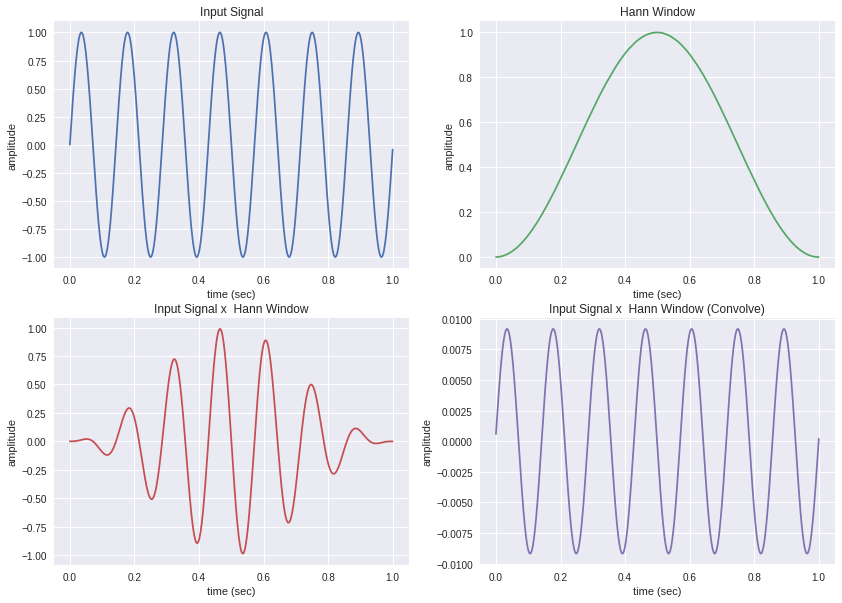

In [15]:
Fs = 1024
f = 7
t = 1

s = sine(A=1, f=f, t=t, Fs=Fs, dtype=np.float64)
hwin = (.5 * (1 - np.cos(2 * np.pi * np.arange(1, window+1) / (window-1)))).astype(np.float16)

sh = hwin * s
shc = np.real(fftpack.ifft(fftpack.fft(hwin) * fftpack.fft(s)))

time = np.linspace(0, t, Fs)
timec = np.linspace(0, t, shc.size)

plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.title('Input Signal')
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.plot(time, s, color='C0')
plt.subplot(222)
plt.title('Hann Window')
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.plot(time, hwin, color='C1')
plt.subplot(223)
plt.title('Input Signal x  Hann Window')
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.plot(time, sh, color='C2')
plt.subplot(224)
plt.title('Input Signal x  Hann Window (Convolve)')
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.plot(timec, shc, color='C3')
plt.show()

### Instantaneous Frequency

"*The frequency of a sinusoidal signal is a well defined quantity. However,  often in practice,  signals are not truly  sinusoidal,  or even aggregates of sinusoidal components. Nonstationary signals in particular do not lend themselves well to  decomposition into sinusoidal components. For such signals, the notion of  frequency loses  its  effectiveness, and one  needs to use  a parameter  which accounts for the time-varying nature of the process. This need has given rise to the idea of instantaneous frequency. The  instantaneous frequency (IF) of a  signal is a  parameter which  is often of significant practical  importance. In many situations  such  as  seismic,  radar,  sonar,  communications, and biomedical  applications,  the  IF is a  good descriptor of some physical phenomenon.*

*...in  many applications the signal  analyst is confronted  with the  task of processing signals whose spectral characteristics (in particular  the  frequency of   the spectral  peaks)  are varying  with time. These  signals are often referred  to as “nonstationary,”  a  simple  example  being the chirp  signal. The latter may be  conceptualized  crudely as a  sine wave whose  frequency  sweeps  with time.*"

*...the Instantaneous Frequency is an important characteristic; it is  a  time-varying  parameter  which defines the  location  of the signal’s spectral peak as it varies  with time. Conceptually it  may be interpreted as the frequency of a  sine wave which  locally fits the signal  under  analysis.  Physically, it has meaning only for monocomponent signals, where there is  only  one  frequency  or  a  narrow  range of frequencies varying as a function of time. For multicomponent  signals, the notion of a single-valued IF becomes  meaningless, and a  break-down  into its components  is needed.*" [UCDavis paper](https://www.math.ucdavis.edu/~saito/data/sonar/boashash1.pdf)

-------------------------------------

So, to test out the concept of **Instantaneous Frequency** let's define a Chirp signal.

"*A chirp is a signal in which the frequency increases (up-chirp) or decreases (down-chirp) with time.*" [wiki](https://en.wikipedia.org/wiki/Chirp)

$f(t) = \sin((2 \pi \frac{k}{2} t^2) + \phi)$

To calculate the **I.F.** one could use a **Hilbert Transform** (or Discrete Hilbert Transform):

*"The Hilbert transform estimates the instantaneous frequency of a signal for monocomponent signals only. A monocomponent signal is described in the time-frequency plane by a single "ridge." The set of monocomponent signals includes single sinusoids, but also includes signals like chirps."* [matlab](https://www.mathworks.com/help/signal/ug/hilbert-transform-and-instantaneous-frequency.html)

$DHT(k) = DFT^{-1}\{H(k) DFT\{Q(k)\}\}$

Finally the **Instantaneous Frequency** can be calculate using the following formula:

$F(t,f) = (\phi_{t,f} - \phi_{t-1,f})\frac{\delta}{2\pi}$

Where the $\phi$ (phi) block (instantaneous phase) is the derivative of phase angles given by the DHT and $\delta$ (delta) is sampling rate.

[7.         7.00225056 7.00450113 7.00675169 7.00900225 7.01125281
 7.01350338 7.01575394 7.0180045  7.02025506 7.02250563 7.02475619
 7.02700675 7.02925731 7.03150788 7.03375844 7.036009   7.03825956
 7.04051013 7.04276069] [15.97974494 15.9819955  15.98424606 15.98649662 15.98874719 15.99099775
 15.99324831 15.99549887 15.99774944 16.        ]
4000
(6.993324207615065e-15+1.4210854715202004e-14j)


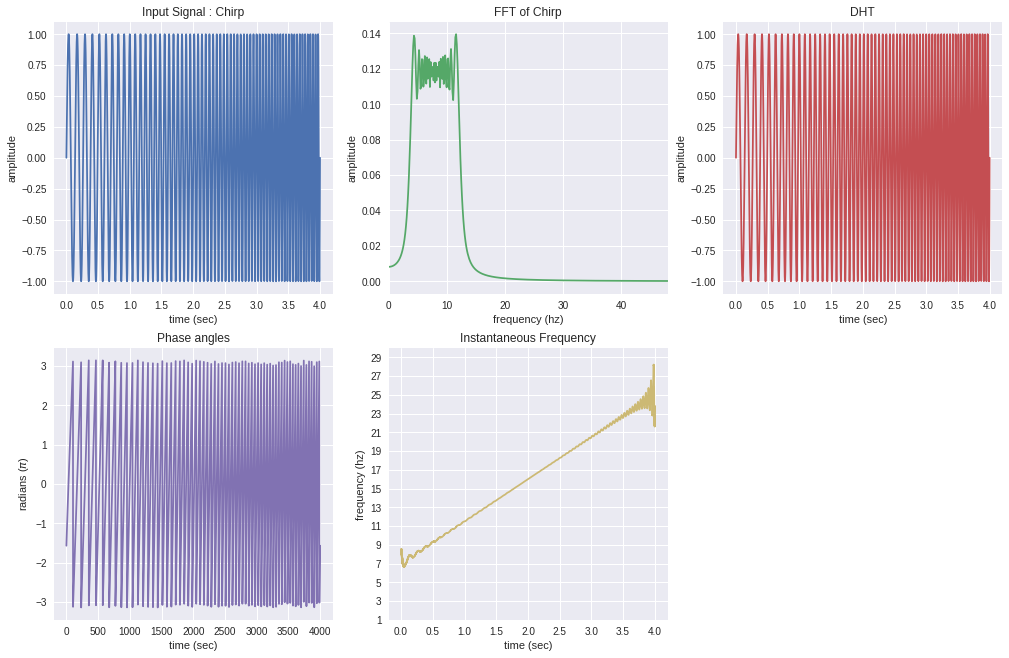

In [102]:
f_s, f_e = 7, np.mean([7, 25])
# Input signal
Fs = 1000 # sampling rate
t = 4
time = np.linspace(0, t, Fs * t)
ff = np.linspace(f_s, f_e, Fs * t)
chirp = np.sin(2 * np.pi * ff * time)

# FFT
C = 2 * np.abs(fftpack.fft(chirp)) / time.size
hz = np.linspace(0, Fs/2, C.size)
ny = int(np.ceil(len(hz)/2))
hz, C = hz[:ny], C[:ny]
m = np.min([int(np.ceil(Fs / 2)), ff[len(ff)-1] * 3])

# DHT : Discrete Hilbert Transform
dht = hilbert(chirp)
angles = np.angle(dht)
# Instantaneous Frequency
instfreq = np.diff(np.unwrap(angles)) * (Fs / (2 * np.pi))
ifq = [1, 30]

print(ff[:20], ff[ff.size-10:])
print(ff.size)
print(np.sum(dht-chirp))

plt.figure(figsize=(17, 11))
plt.subplot(231)
plt.title('Input Signal : Chirp')
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.plot(time, chirp)
plt.subplot(232)
plt.title('FFT of Chirp')
plt.plot(hz, C, color='C1')
plt.xlabel('frequency (hz)')
plt.ylabel('amplitude')
plt.xlim([0, m])
plt.subplot(233)
plt.title('DHT')
plt.plot(time, np.real(dht), color='C2')
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.subplot(234)
plt.title('Phase angles')
plt.plot(angles, color='C3')
plt.xlabel('time (sec)')
plt.ylabel('radians ($\pi$)')
plt.subplot(235)
plt.title('Instantaneous Frequency')
plt.plot(time[1:], instfreq, color='C4')
plt.xlabel('time (sec)')
plt.ylabel('frequency (hz)')
plt.ylim(ifq)
plt.yticks(np.arange(1, 30, 2))
plt.show()